# Joins in Apache Iceberg

Now that we have data for products and orders, let's do some digging around our data

In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = (
    SparkSession.builder
    .appName("Joins in Apache Iceberg")
    .master("spark://spark:7077") 
    .getOrCreate()
)

In [4]:
spark.sql("SELECT * from ice.demo.customers;").show()

+---+--------------+--------------------+-------+
| id|          name|               email|country|
+---+--------------+--------------------+-------+
| 22|      Zoe King|zoe.king@example.com|     US|
| 21|   Jack Wilson|jack.wilson@examp...|     US|
| 15|Isabella Rossi|isabella.rossi@ex...|     US|
|  1|   Alice Smith|   alice@example.com|     US|
|  2|   Bob Johnson|     bob@example.com|     US|
| 12|  Lucas Martin|lucas.martin@exam...|     US|
| 18|   Henry Scott|henry.scott@examp...|     US|
| 16|  James Nguyen|james.nguyen@exam...|     US|
|  5|    Maya Patel|maya.patel@exampl...|     US|
|  7| Sofia Almeida|sofia.almeida@exa...|     US|
| 19|  Aria Johnson|aria.johnson@exam...|     US|
|  3|   Carol Adams|   carol@example.com|     US|
| 20| Daniela Costa|daniela.costa@exa...|     US|
|  4| Diego Ramirez|diego.ramirez@exa...|     US|
|  8| Noah Williams|noah.williams@exa...|     US|
|  9|  Ava Thompson|ava.thompson@exam...|     US|
| 11| Olivia Garcia|olivia.garcia@exa...|     US|


Let's perform a join of the data to see the top customer spends

In [5]:
spark.sql("""
SELECT
    o.customer_id,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent
FROM ice.demo.orders o
JOIN ice.demo.order_items oi
  ON o.id = oi.order_id
JOIN ice.demo.products p
  ON oi.product_id = p.product_id
GROUP BY o.customer_id
ORDER BY total_spent DESC
LIMIT 5
""").show()

+-----------+-----------+
|customer_id|total_spent|
+-----------+-----------+
|         21|    1779.92|
|         14|    1739.92|
|          1|    1679.84|
|         12|    1399.88|
|         15|    1119.88|
+-----------+-----------+



Let's view the order count

In [6]:
spark.sql("""
SELECT
    o.customer_id,
    COUNT(DISTINCT o.id) AS order_count,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent
FROM ice.demo.orders o
JOIN ice.demo.order_items oi
  ON o.id = oi.order_id
JOIN ice.demo.products p
  ON oi.product_id = p.product_id
GROUP BY o.customer_id
ORDER BY total_spent DESC
LIMIT 5
""").show()

+-----------+-----------+-----------+
|customer_id|order_count|total_spent|
+-----------+-----------+-----------+
|         21|          1|    1779.92|
|         14|          1|    1739.92|
|          1|          1|    1679.84|
|         12|          1|    1399.88|
|         15|          1|    1119.88|
+-----------+-----------+-----------+



Let's bring in the name this time to provide something meaningful


In [8]:
spark.sql("""
SELECT
    c.id AS customer_id,
    c.name AS customer_name,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent
FROM ice.demo.orders o
JOIN ice.demo.customers c
  ON o.customer_id = c.id
JOIN ice.demo.order_items oi
  ON o.id = oi.order_id
JOIN ice.demo.products p
  ON oi.product_id = p.product_id
GROUP BY c.id, c.name
ORDER BY total_spent DESC
LIMIT 5
""").show()

+-----------+--------------+-----------+
|customer_id| customer_name|total_spent|
+-----------+--------------+-----------+
|         21|   Jack Wilson|    1779.92|
|         14|  Benjamin Kim|    1739.92|
|          1|   Alice Smith|    1679.84|
|         12|  Lucas Martin|    1399.88|
|         15|Isabella Rossi|    1119.88|
+-----------+--------------+-----------+



Here, we create a graph since we are using Spark and Iceberg in a Jupyter Notebook, this plaform we can use everything in our disposal to represent our data

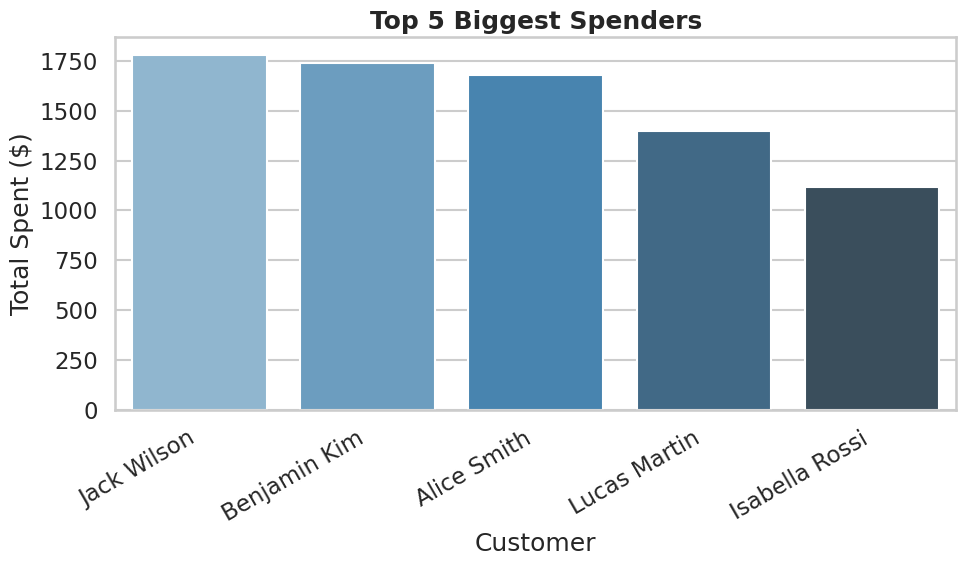

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get Spark results into Pandas
top_spenders_df = spark.sql("""
SELECT
    c.name AS customer_name,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent
FROM ice.demo.orders o
JOIN ice.demo.customers c
  ON o.customer_id = c.id
JOIN ice.demo.order_items oi
  ON o.id = oi.order_id
JOIN ice.demo.products p
  ON oi.product_id = p.product_id
GROUP BY c.name
ORDER BY total_spent DESC
LIMIT 5
""").toPandas()

# Seaborn style
sns.set(style="whitegrid", context="talk")

# Updated plot — assigns hue and disables legend
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_spenders_df,
    x="customer_name",
    y="total_spent",
    hue="customer_name",
    dodge=False,
    legend=False,
    palette="Blues_d"
)

plt.title("Top 5 Biggest Spenders", fontsize=18, weight="bold")
plt.xlabel("Customer")
plt.ylabel("Total Spent ($)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [11]:
spark.stop()